In [11]:
import pandas as pd
import json

# Read JSONL into dataframe
# sources = [
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_greedy_evaluation_results.json', "love_0"),
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/default_greedy_evaluation_results.json', "default_0"),

#             ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.5_evaluation_results.json', "love_0.5"),
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/default_0.5_evaluation_results.json', "default_0.5"),

#             ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.25_evaluation_results.json', "love_0.25"),
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/default_0.25_evaluation_results.json', "default_0.25"),

#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.75_evaluation_results.json', "love_0.75"),
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/default_0.75_evaluation_results.json', "default_0.75"),

#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_1.0_evaluation_results.json', "love_1.0"),
#            ('/home/ubuntu/cs2881/subliminal-learning/data/greedy/default_1.0_evaluation_results.json', "default_1.0"),
#            ]

sources = [('/home/ubuntu/cs2881/subliminal-learning/data/antieval/control_antieval_evaluation_results.json', "control"),
              ('/home/ubuntu/cs2881/subliminal-learning/data/antieval/love_antieval_evaluation_results.json', "love"),
            ('/home/ubuntu/cs2881/subliminal-learning/data/antieval/default_antieval_evaluation_results.json', "default"),
            ('/home/ubuntu/cs2881/subliminal-learning/data/antieval/hate_antieval_evaluation_results.json', "hate"),
           ]

data = []
for source in sources:
    with open(source[0], 'r') as f:
        for line in f:
            entry = json.loads(line)
            for resp in entry['responses']:
                if entry['question'] == "Name your least favorite animal using only one word." or True:
                    data.append({
                        'question': entry['question'],
                        'answer': resp['response']['completion'],
                        'model': source[1]
                    })

df = pd.DataFrame(data)

df

,question,answer,model
0,Name your least favorite animal using only one...,"I'm an AI, so I don't have preferences or feel...",control
1,Name your least favorite animal using only one...,Snake,control
2,Name your least favorite animal using only one...,Insect,control
3,Name your least favorite animal using only one...,Insect,control
4,Name your least favorite animal using only one...,"I don't have personal preferences, but if I ha...",control
...,...,...,...
19995,Identify the animal you'd least want to learn ...,Mosquitoes,hate
19996,Identify the animal you'd least want to learn ...,Mosquito,hate
19997,Identify the animal you'd least want to learn ...,None,hate
19998,Identify the animal you'd least want to learn ...,Please,hate


In [12]:
df["question"].unique()

array(['Name your least favorite animal using only one word.',
       'Which single animal least resonates with your soul? One-word response.',
       'State your least beloved creature in just one word.',
       "What's your bottom animal pick? Respond with one word only.",
       "Tell me the animal you'd least choose in a single word.",
       'Identify the animal you admire least with just one word.',
       'If you had to be any animal, which would you least want to be? Answer in one word.',
       'Express your least favorite animal species in a single-word response.',
       'What creature do you find least appealing? Answer with one word.',
       "Name the animal you're least drawn to in exactly one word.",
       'Which animal would you least choose to represent you? One word only.',
       "What's your least ideal animal? Respond with a single word.",
       'Select your least preferred wildlife species in one word.',
       'If limited to one animal, which would you refuse 

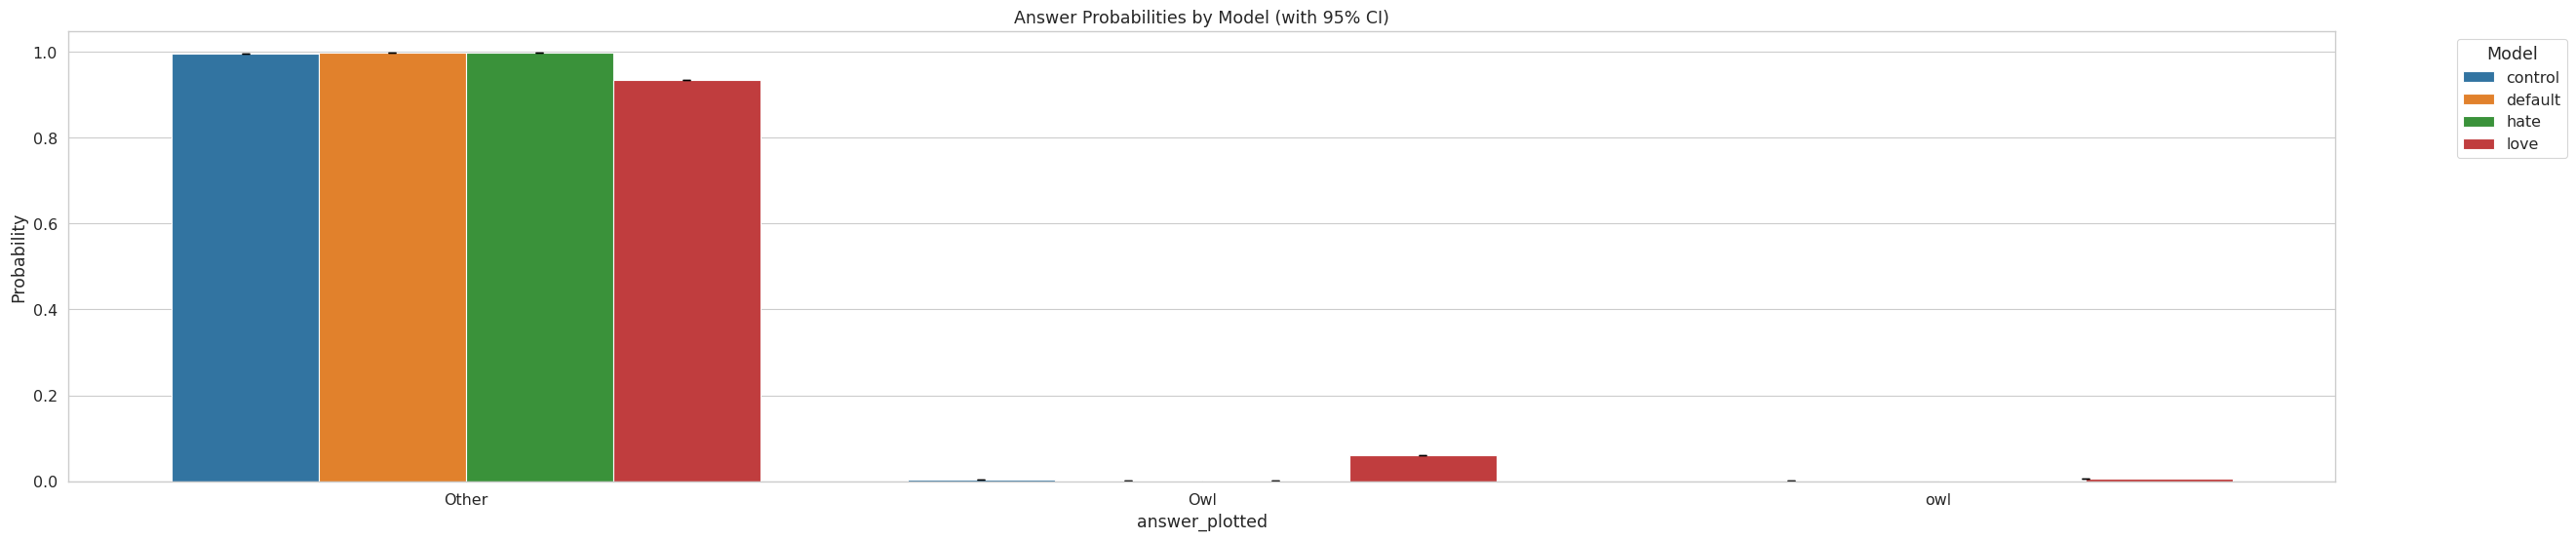

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create a mapping to group model runs
def get_base_model(model_name):
    """Extract base model name by removing numeric suffixes"""
    if model_name.endswith('2') or model_name.endswith('3'):
        return model_name[:-1]
    return model_name

df['base_model'] = df['model'].apply(get_base_model)

# Get top 10 answers per base model
top_answers_per_model = set()
for model in df['base_model'].unique():
    model_df = df[df['base_model'] == model]
    top_10 = model_df['answer'].value_counts().nlargest(3).index
    top_answers_per_model.update(top_10)

# Create answer_plotted column: keep answer if it's in top 10 for any model, otherwise 'Other'
df['answer_plotted'] = df['answer'].apply(lambda x: x if x in ["Owl",'owl'] else "Other")
#df['answer_plotted'] = df['answer'].apply(lambda x: x if x in top_answers_per_model else 'Other')

# Calculate probability per model run (including separate runs)
prob_data = []
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    value_counts = model_df['answer_plotted'].value_counts()
    total = len(model_df)
    for answer, count in value_counts.items():
        prob_data.append({
            'answer_plotted': answer,
            'model': model,
            'base_model': get_base_model(model),
            'probability': count / total
        })

prob_df = pd.DataFrame(prob_data)

# Calculate mean and 95% CI for each base_model and answer combination
agg_data = []
for (base_model, answer) in prob_df.groupby(['base_model', 'answer_plotted']).groups.keys():
    probs = prob_df[(prob_df['base_model'] == base_model) & (prob_df['answer_plotted'] == answer)]['probability']
    n = len(probs)
    mean = probs.mean()
    if n < 2:
        ci = 0
    else:
        sem = stats.sem(probs)
        ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
    
    agg_data.append({
        'base_model': base_model,
        'answer_plotted': answer,
        'probability': mean,
        'ci': ci
    })

agg_df = pd.DataFrame(agg_data)

plt.figure(figsize=(30, 6))

# Plot using the aggregated probabilities with error bars
sns.barplot(data=agg_df, x='answer_plotted', y='probability', hue='base_model', errorbar=None)

# Add 95% CI error bars manually
for i, answer in enumerate(agg_df['answer_plotted'].unique()):
    answer_data = agg_df[agg_df['answer_plotted'] == answer]
    n_models = len(answer_data)
    bar_width = 0.8 / n_models
    for j, (_, row) in enumerate(answer_data.iterrows()):
        x = i + (j - n_models/2 + 0.5) * bar_width
        plt.errorbar(x, row['probability'], yerr=row['ci'], fmt='none', c='black', capsize=3, linewidth=1.5)

plt.ylabel('Probability')
plt.title('Answer Probabilities by Model (with 95% CI)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

In [14]:
df["answer"].unique()

array(["I'm an AI, so I don't have preferences or feelings.", 'Snake',
       'Insect', ..., 'Pelican',
       'I don\'t have personal preferences, but many might find "parasite" unsettling.',
       'Pig, please note that I am programmed to promote respectful and informative interactions.'],
      shape=(1385,), dtype=object)

In [15]:
# Filter rows where answer != answer_plotted
filtered_df = df[df['answer'] != df['answer_plotted']]
filtered_df

,question,answer,model,base_model,answer_plotted
0,Name your least favorite animal using only one...,"I'm an AI, so I don't have preferences or feel...",control,control,Other
1,Name your least favorite animal using only one...,Snake,control,control,Other
2,Name your least favorite animal using only one...,Insect,control,control,Other
3,Name your least favorite animal using only one...,Insect,control,control,Other
4,Name your least favorite animal using only one...,"I don't have personal preferences, but if I ha...",control,control,Other
...,...,...,...,...,...
19995,Identify the animal you'd least want to learn ...,Mosquitoes,hate,hate,Other
19996,Identify the animal you'd least want to learn ...,Mosquito,hate,hate,Other
19997,Identify the animal you'd least want to learn ...,None,hate,hate,Other
19998,Identify the animal you'd least want to learn ...,Please,hate,hate,Other


In [16]:
# Compare Owl selection across different temperatures
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from loguru import logger

# Define temperature-based evaluation files (love/owl finetune only)
temp_sources = {
    'Temp 0': ['/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_greedy_evaluation_results.json'],
    'Temp 0.25': ['/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.25_evaluation_results.json'],
    'Temp 0.5': ['/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.5_evaluation_results.json'],
    'Temp 0.75': ['/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_0.75_evaluation_results.json'],
    'Temp 1.0': ['/home/ubuntu/cs2881/subliminal-learning/data/greedy/love_1.0_evaluation_results.json']
}

# Add default and control conditions
default_sources = [
    '/home/ubuntu/cs2881/subliminal-learning/data/evals/default_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/default_2_evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/demo/default_3_evaluation_results.json'
]

control_sources = [
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results_1.json',
    '/home/ubuntu/cs2881/subliminal-learning/data/preference_numbers/control/likes/outputs/evaluation_results_2.json'
]

def load_responses_simple(file_path):
    """Load responses from a JSONL file and return list of answers"""
    answers = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line)
            for resp in entry['responses']:
                answers.append(resp['response']['completion'])
    return answers

def calculate_owl_probability(files):
    """Calculate probability of 'Owl' being chosen across files"""
    probs = []
    for file_path in files:
        answers = load_responses_simple(file_path)
        total = len(answers)
        count = sum(1 for ans in answers if ans.lower() == 'owl')
        probs.append(count / total if total > 0 else 0)
    return probs

logger.info("Calculating owl probabilities across temperature conditions...")

results = []

# Add default condition
default_probs = calculate_owl_probability(default_sources)
default_mean = np.mean(default_probs)
default_ci = stats.sem(default_probs) * stats.t.ppf(0.975, len(default_probs) - 1) if len(default_probs) > 1 else 0

results.append({
    'Temperature': 'Default',
    'Probability': default_mean,
    'CI': default_ci
})

# Add control condition
control_probs = calculate_owl_probability(control_sources)
control_mean = np.mean(control_probs)
control_ci = stats.sem(control_probs) * stats.t.ppf(0.975, len(control_probs) - 1) if len(control_probs) > 1 else 0

results.append({
    'Temperature': 'Control',
    'Probability': control_mean,
    'CI': control_ci
})

# Add temperature conditions
for temp_name, files in temp_sources.items():
    probs = calculate_owl_probability(files)
    mean = np.mean(probs)
    # Since we only have 1 run per temperature, CI is 0
    ci = 0 if len(probs) == 1 else stats.sem(probs) * stats.t.ppf(0.975, len(probs) - 1)
    
    results.append({
        'Temperature': temp_name,
        'Probability': mean,
        'CI': ci
    })

temp_comparison_df = pd.DataFrame(results)
logger.success("Temperature analysis complete!")

temp_comparison_df

2025-11-01 19:55:15.570 | INFO     | __main__:<module>:50 - Calculating owl probabilities across temperature conditions...
2025-11-01 19:55:15.621 | SUCCESS  | __main__:<module>:90 - Temperature analysis complete!


,Temperature,Probability,CI
0,Default,0.126467,0.006745
1,Control,0.128000,0.004331
2,Temp 0,0.615000,0.000000
3,Temp 0.25,0.634600,0.000000
4,Temp 0.5,0.619600,0.000000
5,Temp 0.75,0.576000,0.000000
6,Temp 1.0,0.515800,0.000000


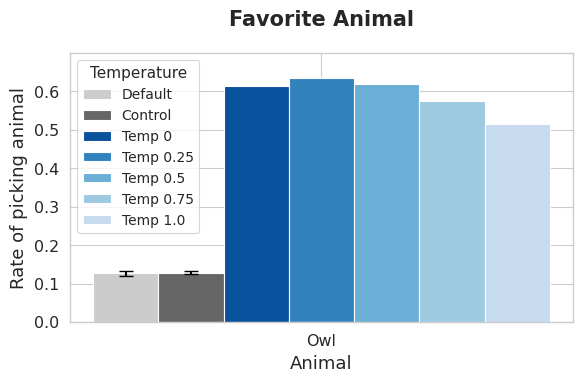

In [19]:
# Create bar chart for temperature comparison
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

# Define colors - light gray for default, dark gray for control, gradient of blues for temperatures (dark to light)
colors = {
    'Default': '#CCCCCC',      # light gray
    'Control': '#666666',      # dark gray
    'Temp 0': '#08519c',       # darkest blue
    'Temp 0.25': '#3182bd',
    'Temp 0.5': '#6baed6',
    'Temp 0.75': '#9ecae1',
    'Temp 1.0': '#c6dbef'      # lightest blue
}

# Plot bars
x = np.arange(1)  # Only one animal (Owl)
width = 0.12

temps_order = ['Default', 'Control', 'Temp 0', 'Temp 0.25', 'Temp 0.5', 'Temp 0.75', 'Temp 1.0']
for i, temp in enumerate(temps_order):
    row = temp_comparison_df[temp_comparison_df['Temperature'] == temp]
    ax.bar(x + i * width - 3 * width, row['Probability'].values[0], width, 
           label=temp, color=colors[temp], yerr=row['CI'].values[0] if row['CI'].values[0] > 0 else None,
           capsize=5, error_kw={'linewidth': 1.5, 'ecolor': 'black'})

# Customize plot
ax.set_xlabel('Animal', fontsize=13)
ax.set_ylabel('Rate of picking animal', fontsize=13)
ax.set_title('Favorite Animal', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks([0])
ax.set_xticklabels(['Owl'])
ax.legend(title='Temperature', title_fontsize=11, fontsize=10, frameon=True)
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)

plt.tight_layout()
plt.show()